## Deep Learning

> Antonopoulos Ilias (p3352004) <br />
> Ndoja Silva (p3352017) <br />
> MSc Data Science AUEB

## Table of Contents

- [Data Loading](#Data-Loading)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Model Selection](#Model-Selection)
- [Evaluation](#Evaluation)

In [51]:
from ast import literal_eval
from time import time

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from matplotlib import offsetbox
from sklearn import decomposition
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.manifold import TSNE

In [2]:
print(tf.__version__)

2.8.0


In [15]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  0


**tip**: Open the Google Colab link for a GPU runtime:

<a href="https://colab.research.google.com/github/fashion-mnist-classification/MLPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

### Data Loading

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [7]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [8]:
test_images.shape

(10000, 28, 28)

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
  along with a test set of 10,000 images.
  
The classes are:
  
| Label | Description |
|:-----:|-------------|
|   0   | T-shirt/top |
|   1   | Trouser     |
|   2   | Pullover    |
|   3   | Dress       |
|   4   | Coat        |
|   5   | Sandal      |
|   6   | Shirt       |
|   7   | Sneaker     |
|   8   | Bag         |
|   9   | Ankle boot  |

In [9]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

### Exploratory Data Analysis

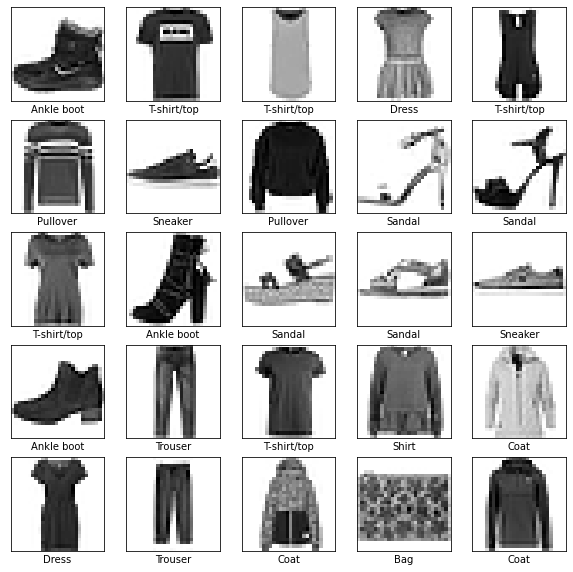

In [11]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [52]:
def visualize_input(img, ax):
    ax.imshow(img, cmap="summer")
    width, height = img.shape
    thresh = img.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(
                str(round(img[x][y], 2)),
                xy=(y, x),
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if img[x][y] < thresh else "black",
            )

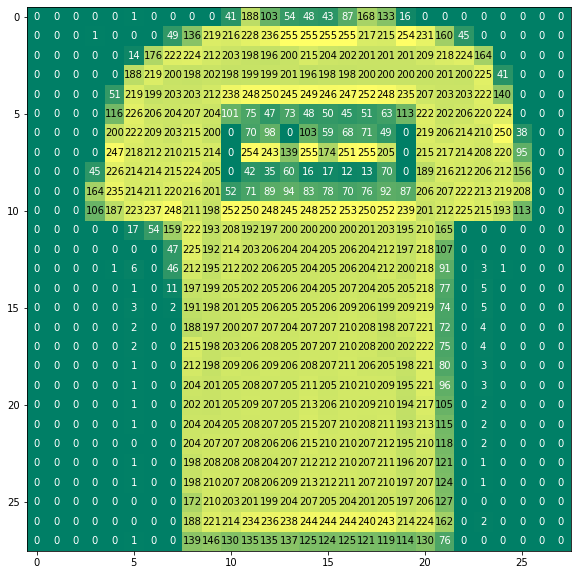

In [53]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
visualize_input(train_images[1], ax)
plt.show()

In [54]:
X_train = train_images.copy().reshape(60000, 784)

y_train = train_labels.copy()

X_train_standardized = StandardScaler().fit_transform(X_train)

X_train_normalized = Normalizer().fit_transform(X_train_standardized)

X_train_tsne = TSNE(n_components=2, init="random", learning_rate=200).fit_transform(
    X_train_normalized
)

In [55]:
colors = [
    "rgb(0,31,63)",
    "rgb(255,133,27)",
    "rgb(255,65,54)",
    "rgb(0,116,217)",
    "rgb(133,20,75)",
    "rgb(57,204,204)",
    "rgb(240,18,190)",
    "rgb(46,204,64)",
    "rgb(1,255,112)",
    "rgb(255,220,0)",
    "rgb(76,114,176)",
    "rgb(85,168,104)",
    "rgb(129,114,178)",
    "rgb(100,181,205)",
]

In [56]:
def plot_tsne_embedding(X_train_tsne, y):
    plt.rcParams["figure.figsize"] = [21, 18]
    for k, i in enumerate(np.unique(y.astype(int))):
        plt.scatter(
            X_train_tsne[y == i, 0],
            X_train_tsne[y == i, 1],
            color="#%02x%02x%02x" % literal_eval(colors[k][3:]),
            label=class_names[k],
        )
    plt.legend()
    plt.show()

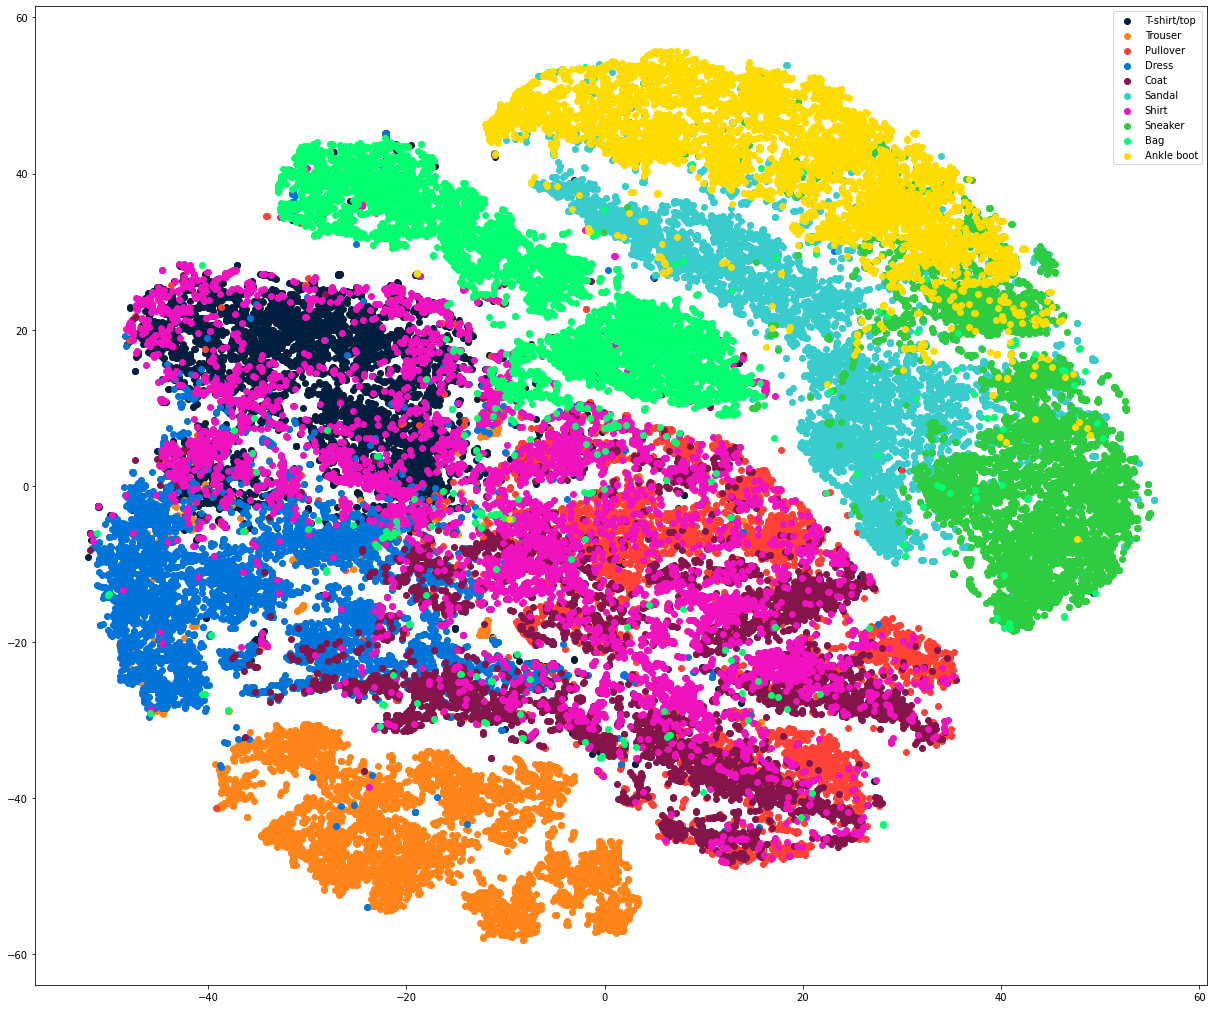

In [57]:
plot_tsne_embedding(X_train_tsne, y_train)

In [58]:
def plot_tsne_embedding_v2(X, X_origin, title=None, dims=[None, 28, 28]):
    dims[0] = X.shape[0]
    X_origin = X_origin.astype(float).reshape(dims)
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(
            X[i, 0],
            X[i, 1],
            str(y_train[i]),
            color=plt.cm.Set1(y_train.astype(int)[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )

    if hasattr(offsetbox, "AnnotationBbox"):
        shown_images = np.array([[1.0, 1.0]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 3e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X_origin[i], cmap=plt.cm.gray_r), X[i]
            )
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

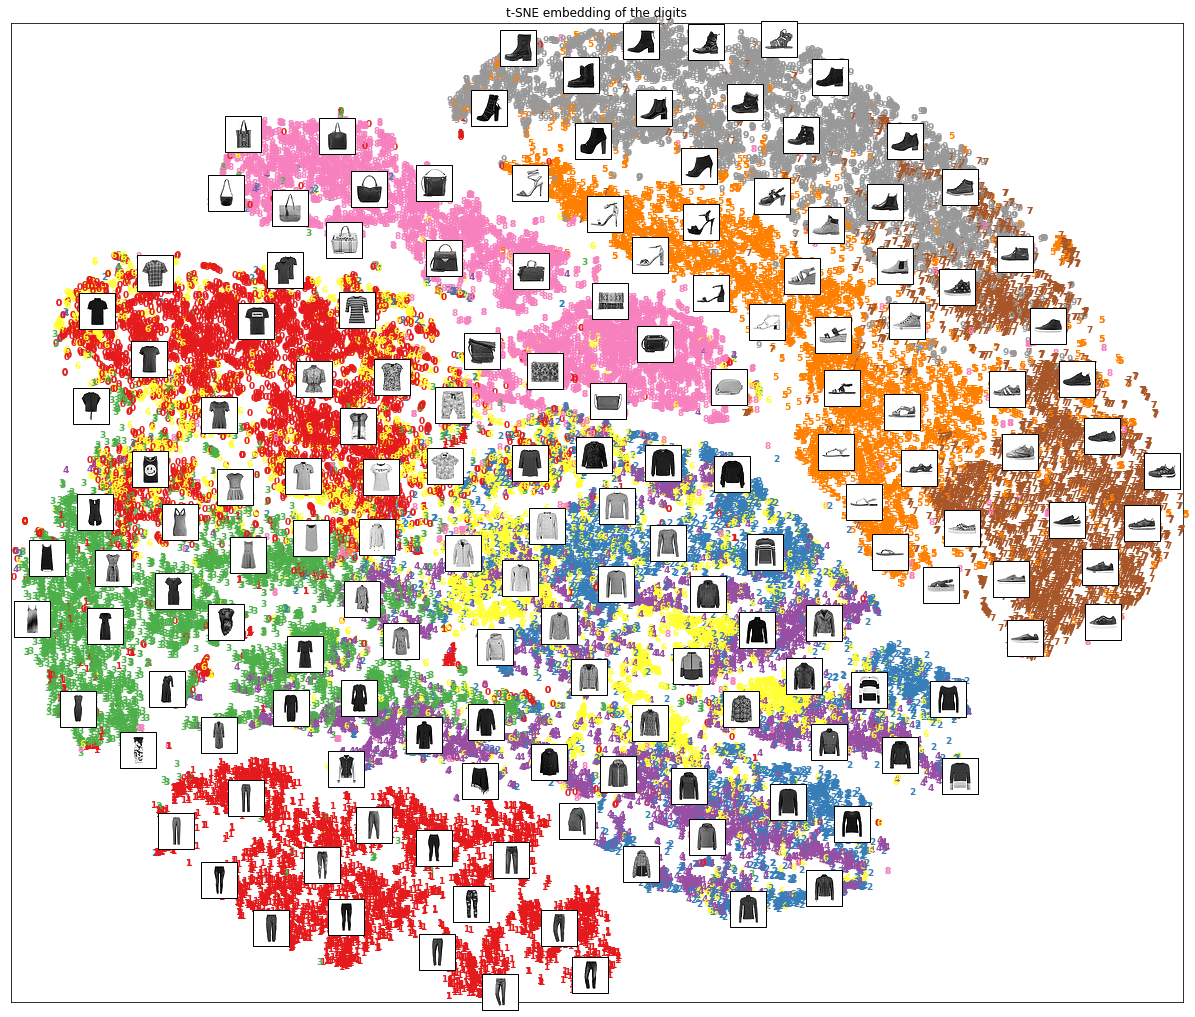

In [59]:
plot_tsne_embedding_v2(X_train_tsne, X_train, "t-SNE embedding of the digits")

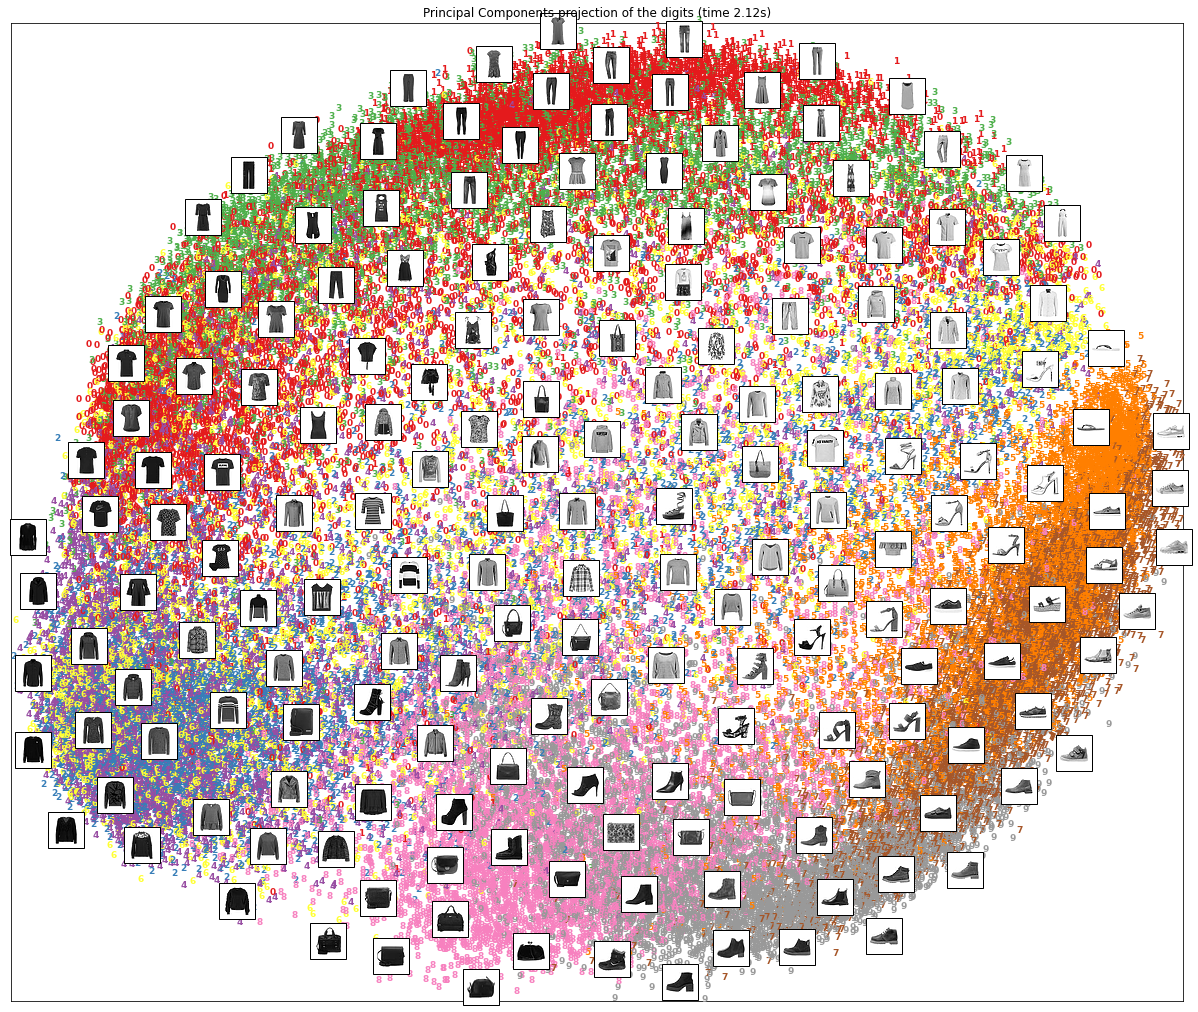

In [61]:
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X_train_normalized)
plot_tsne_embedding_v2(
    X_pca,
    X_train,
    "Principal Components projection of the digits (time %.2fs)" % (time() - t0),
)

### Hyperparameter Tuning

In [16]:
SEED = 123456

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [17]:
def mlp_model_builder(hp):
    """Creates a HyperModel instance (or callable that takes hyperparameters and returns a Model instance)."""
    hp_activation_func = hp.Choice("activation_func", values=["relu", "elu"])
    hp_units = hp.Int("units", min_value=32, max_value=512, step=32)
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Rescaling(scale=1.0 / 255))
    model.add(
        tf.keras.layers.Dense(
            units=hp_units, kernel_initializer="glorot_uniform", activation="relu"
        )
    )
    model.add(
        tf.keras.layers.Dense(
            units=10,
            kernel_initializer="glorot_uniform",
        )
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

In [18]:
# Li, Lisha, and Kevin Jamieson.
# "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization."
# Journal of Machine Learning Research 18 (2018): 1-52.
# https://jmlr.org/papers/v18/16-558.html
tuner = kt.Hyperband(
    mlp_model_builder,
    objective="val_accuracy",
    max_epochs=50,  # the maximum number of epochs to train one model
    seed=SEED,
    directory="hparam-tuning",
    project_name="mlp",
)

2022-02-26 17:22:51.551907: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [31]:
tuner.search(
    train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[stop_early]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(
    f"""
The hyperparameter search is complete. \n

Results
=======
|
---- optimal number of units in the first densely-connected layer : {best_hps.get('units')}
|
---- optimal learning rate for the optimizer : {best_hps.get('learning_rate')}
|
---- optimal activation function : {best_hps.get('activation_func')}
"""
)


The hyperparameter search is complete. 


Results
|
---- optimal number of units in the first densely-connected layer : 512
|
---- optimal learning rate for the optimizer : 0.0001
|
---- optimal activation function : elu



#### Model Selection

In [45]:
# build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs=50, validation_split=0.2)

# keep best epoch
val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6211 - accuracy: 0.7983 - val_loss: 0.4827 - val_accuracy: 0.8356
Epoch 2/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4388 - accuracy: 0.8508 - val_loss: 0.4227 - val_accuracy: 0.8553
Epoch 3/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3973 - accuracy: 0.8635 - val_loss: 0.4168 - val_accuracy: 0.8577
Epoch 4/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3712 - accuracy: 0.8711 - val_loss: 0.3906 - val_accuracy: 0.8640
Epoch 5/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3520 - accuracy: 0.8766 - val_loss: 0.3672 - val_accuracy: 0.8723
Epoch 6/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3364 - accuracy: 0.8816 - val_loss: 0.3517 - val_accuracy: 0.8778
Epoch 7/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3228 - accuracy: 0.8864 - val_loss: 0.3432 - val_accuracy:

In [46]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_images, train_labels, epochs=best_epoch, validation_split=0.2)

Epoch 1/45
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6276 - accuracy: 0.7952 - val_loss: 0.4869 - val_accuracy: 0.8352
Epoch 2/45
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4412 - accuracy: 0.8499 - val_loss: 0.4211 - val_accuracy: 0.8562
Epoch 3/45
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3986 - accuracy: 0.8621 - val_loss: 0.4123 - val_accuracy: 0.8577
Epoch 4/45
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3722 - accuracy: 0.8718 - val_loss: 0.3886 - val_accuracy: 0.8639
Epoch 5/45
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3529 - accuracy: 0.8763 - val_loss: 0.3660 - val_accuracy: 0.8717
Epoch 6/45
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3376 - accuracy: 0.8809 - val_loss: 0.3504 - val_accuracy: 0.8788
Epoch 7/45
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3243 - accuracy: 0.8854 - val_loss: 0.3425 - val_accuracy:

### Evaluation

In [47]:
eval_result = hypermodel.evaluate(test_images, test_labels, verbose=3)
print("[test loss, test accuracy]:", eval_result)

[test loss, test accuracy]: [0.3196049928665161, 0.8955000042915344]
